# Datos muy desequilibrados

- Pau Adell Raventos
- Joan Sales De Marcos
- Iván González Reguera
- José Morote García

En los dominios médicos, los conjuntos de datos suelen tener un gran desequilibrio que dificulta
la obtención de un modelo con buena precisión que realmente discrimine las clases que nos
interesan. Vamos a trabajar con el conjunto de datos HCV del repositorio de conjuntos de datos
de UCI que recopila medidas de muestras de sangre que corresponden a individuos sanos y
pacientes con hepatitis C (https://archive.ics.uci.edu/ml/datasets/HCV+data). Leed
primero la documentación del conjunto de datos.
El objetivo de este problema es construir un clasificador que prediga si el ejemplo corresponde
a una de las cuatro clases que tenemos (persona sana (Donante de Sangre) o una de las otras tres
clases). Esta es una tarea más difícil que el objetivo original del conjunto de datos.

Importemos algunas librerías que serán necesarias

In [ ]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

Cargamos los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def find_folder(folder_name, start_path='/content/drive/My Drive'):
    for root, dirs, files in os.walk(start_path):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

shared_folder_path = find_folder("APA")

hcv_folder_path = os.path.join(shared_folder_path, "hcv+data")

def list_contents(directory_path):
    return os.listdir(directory_path)

# For example, to list contents of the bike_folder_path
contents = list_contents(hcv_folder_path)
contents

['hcvdat0.xlsx', 'hcvdat0.csv']

In [ ]:
hcv =  pd.read_csv(hcv_folder_path + "/hcvdat0.csv", header=0, delimiter=',')
hcv.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


Veamos una breve descripción para ver qué datos tenemos, sus valores y cuántos tenemos de estos.

In [ ]:
hcv.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,615.0,NaN,NaN,NaN,308.0,177.679487,1.0,154.5,308.0,461.5,615.0
Category,615,5,0=Blood Donor,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,615.0,NaN,NaN,NaN,47.40813,10.055105,19.0,39.0,47.0,54.0,77.0
Sex,615,2,m,377,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,614.0,NaN,NaN,NaN,41.620195,5.780629,14.9,38.8,41.95,45.2,82.2
ALP,597.0,NaN,NaN,NaN,68.28392,26.028315,11.3,52.5,66.2,80.1,416.6
ALT,614.0,NaN,NaN,NaN,28.450814,25.469689,0.9,16.4,23.0,33.075,325.3
AST,615.0,NaN,NaN,NaN,34.786341,33.09069,10.6,21.6,25.9,32.9,324.0
BIL,615.0,NaN,NaN,NaN,11.396748,19.67315,0.8,5.3,7.3,11.2,254.0
CHE,615.0,NaN,NaN,NaN,8.196634,2.205657,1.42,6.935,8.26,9.59,16.41


Como podemos ver a continuación, las variables que presentan valores perdidos son 'ALP', 'CHOL', 'ALB', 'ALT' y 'PROT'.

Todos los valores perdidos pertenecen a variables numéricas, por lo tanto son fácilmente imputables usando la media del atributo.

In [ ]:
hcv.isna().sum().sort_values(ascending=False)

ALP           18
CHOL          10
ALB            1
ALT            1
PROT           1
Unnamed: 0     0
Category       0
Age            0
Sex            0
AST            0
BIL            0
CHE            0
CREA           0
GGT            0
dtype: int64

In [ ]:
columns_to_fill = ['ALP', 'CHOL', 'ALT', 'PROT', 'ALB']

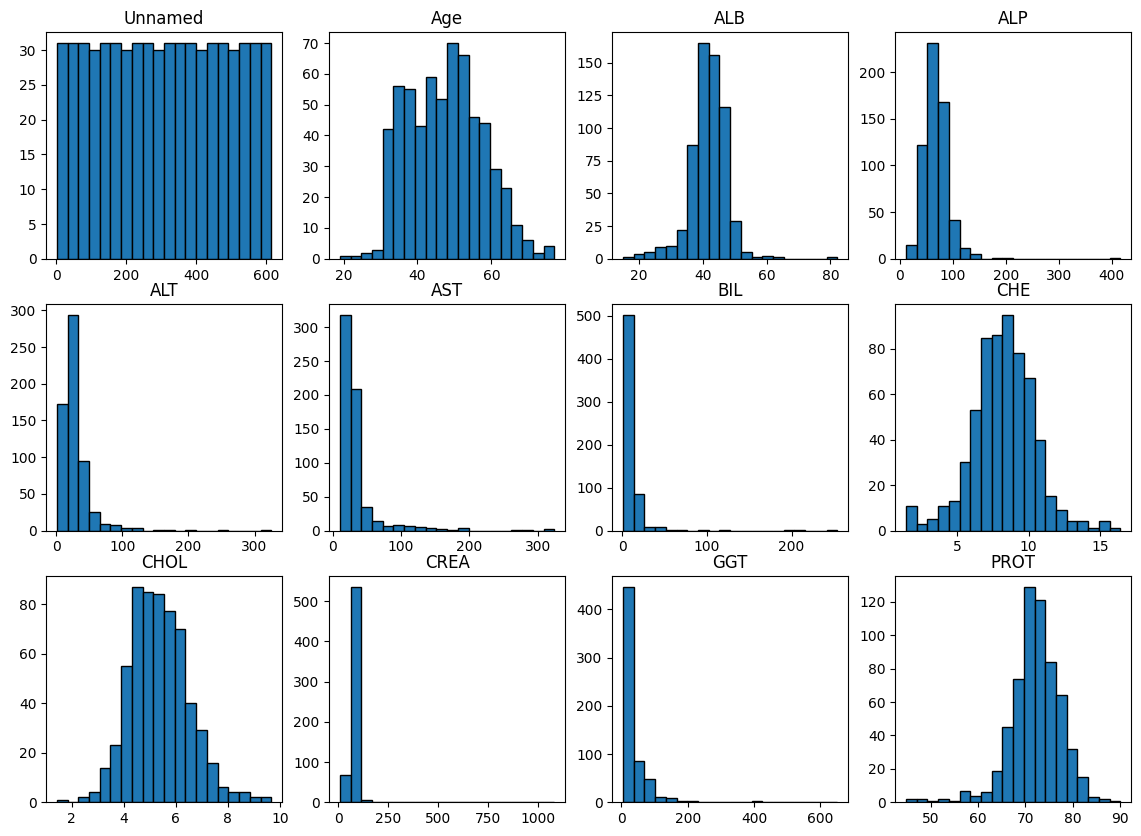

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,10))

ax[0][0].hist(hcv['Unnamed: 0'], bins=20, edgecolor='black');
ax[0][0].set_title('Unnamed');
ax[0][1].hist(hcv['Age'], bins=20, edgecolor='black');
ax[0][1].set_title('Age');
ax[0][2].hist(hcv['ALB'], bins=20, edgecolor='black');
ax[0][2].set_title('ALB');
ax[0][3].hist(hcv['ALP'], bins=20, edgecolor='black');
ax[0][3].set_title('ALP');

ax[1][0].hist(hcv['ALT'], bins=20, edgecolor='black');
ax[1][0].set_title('ALT');
ax[1][1].hist(hcv['AST'], bins=20, edgecolor='black');
ax[1][1].set_title('AST');
ax[1][2].hist(hcv['BIL'], bins=20, edgecolor='black');
ax[1][2].set_title('BIL');
ax[1][3].hist(hcv['CHE'], bins=20, edgecolor='black');
ax[1][3].set_title('CHE');

ax[2][0].hist(hcv['CHOL'], bins=20, edgecolor='black');
ax[2][0].set_title('CHOL');
ax[2][1].hist(hcv['CREA'], bins=20, edgecolor='black');
ax[2][1].set_title('CREA');
ax[2][2].hist(hcv['GGT'], bins=20, edgecolor='black');
ax[2][2].set_title('GGT');
ax[2][3].hist(hcv['PROT'], bins=20, edgecolor='black');
ax[2][3].set_title('PROT');

Nuestra variable unnamed parece no dar informacion necesaria y las variables categóricas las miraremos más tarde.

Ahora observemos la relacion de nuestras variables con la variable objetivo (Category) la cual puede tener los siguientes valores: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'.

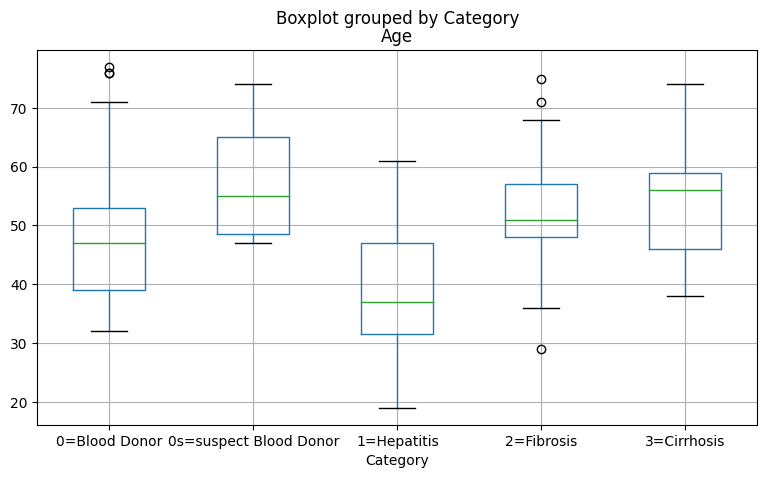

In [ ]:
hcv.boxplot(column = 'Age', by ='Category',figsize = (9,5));

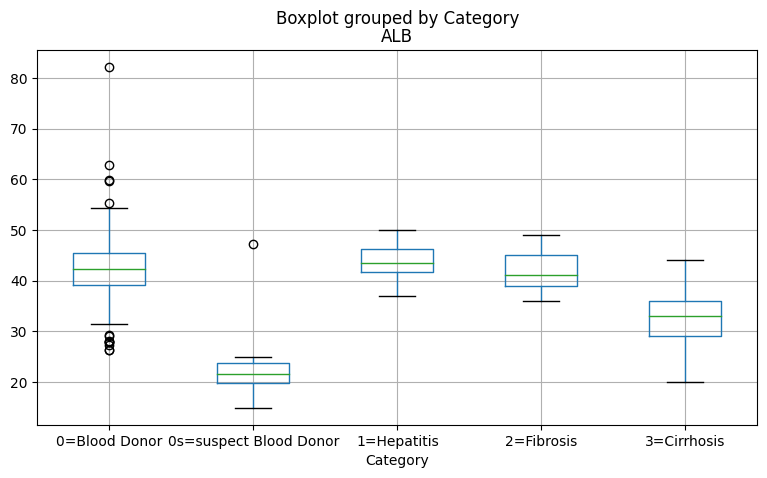

In [ ]:
hcv.boxplot(column = 'ALB', by ='Category',figsize = (9,5));

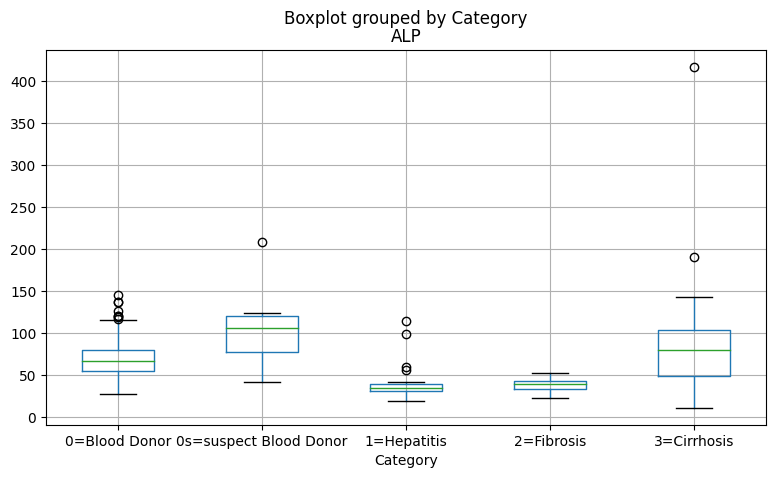

In [ ]:
hcv.boxplot(column = 'ALP', by ='Category',figsize = (9,5));

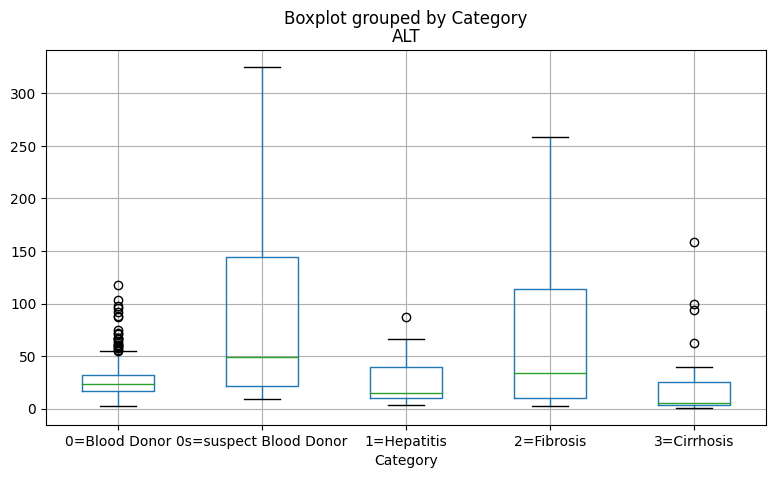

In [ ]:
hcv.boxplot(column = 'ALT', by ='Category',figsize = (9,5));

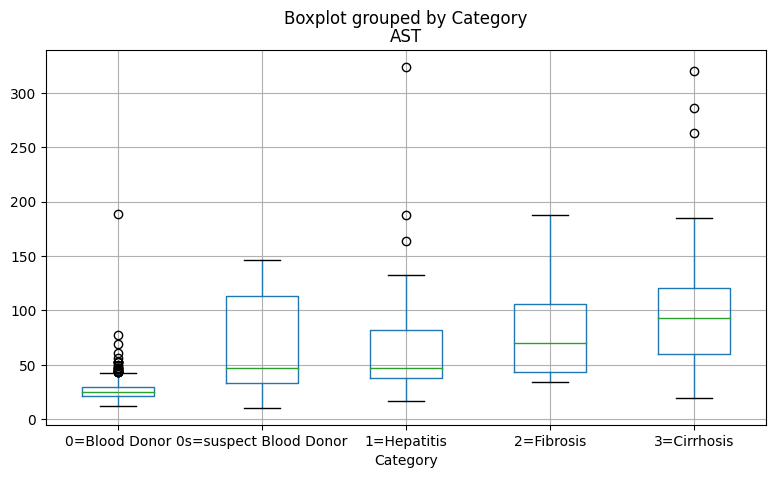

In [ ]:
hcv.boxplot(column = 'AST', by ='Category',figsize = (9,5));

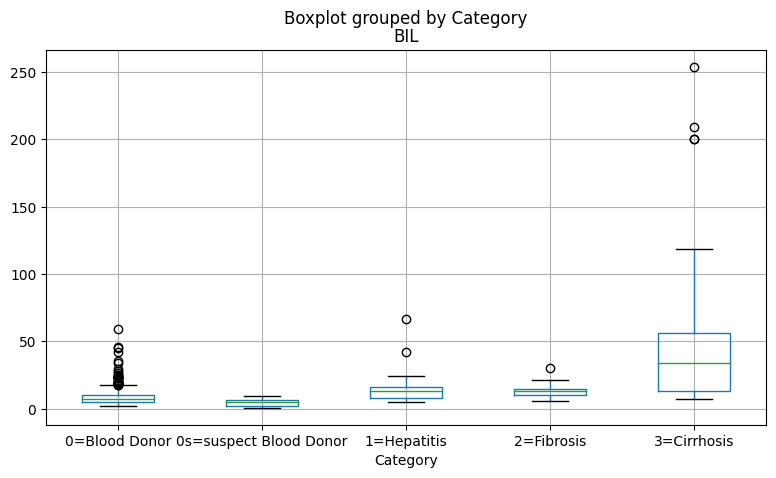

In [ ]:
hcv.boxplot(column = 'BIL', by ='Category',figsize = (9,5));

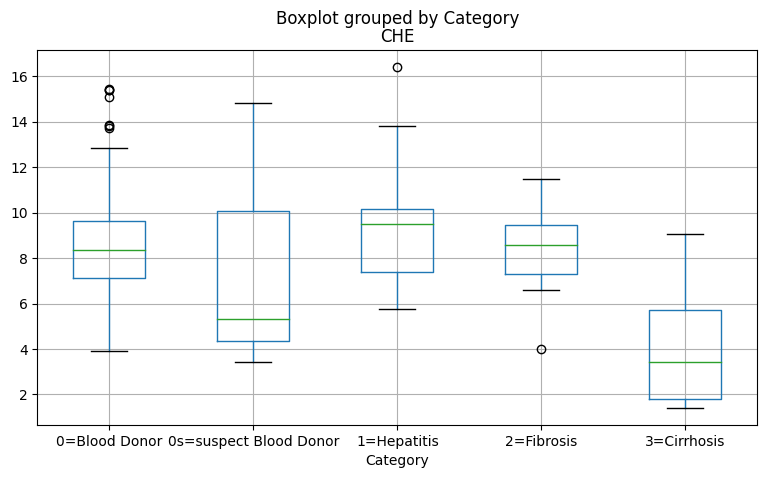

In [ ]:
hcv.boxplot(column = 'CHE', by ='Category',figsize = (9,5));

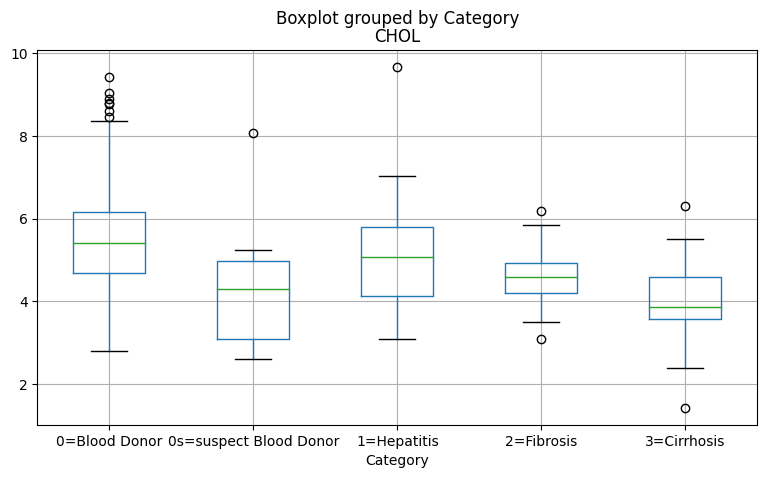

In [ ]:
hcv.boxplot(column = 'CHOL', by ='Category',figsize = (9,5));

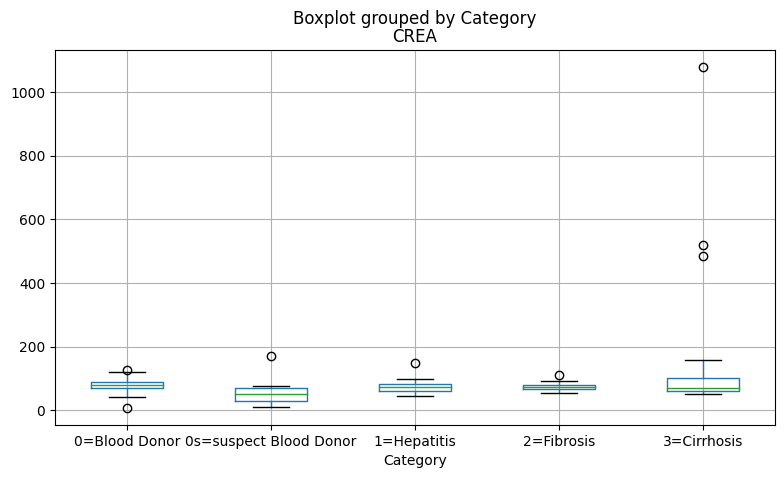

In [ ]:
hcv.boxplot(column = 'CREA', by ='Category',figsize = (9,5));

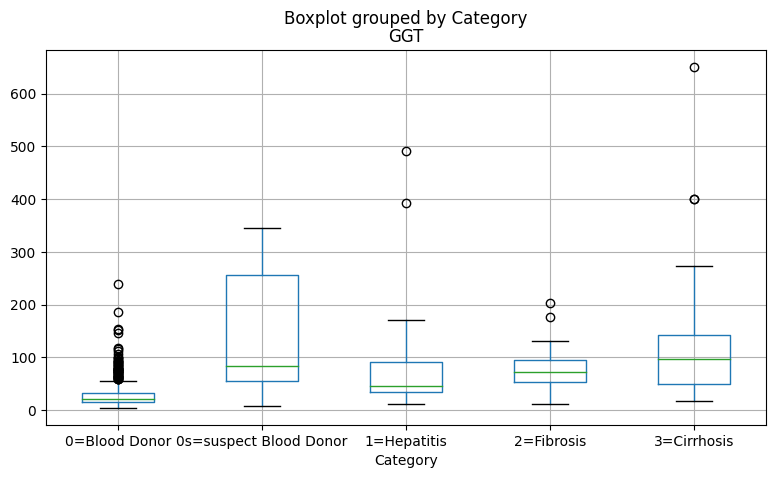

In [ ]:
hcv.boxplot(column = 'GGT', by ='Category',figsize = (9,5));

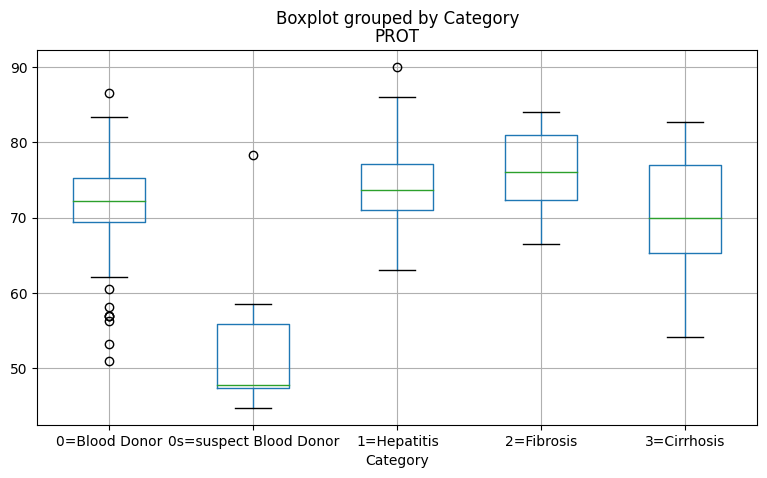

In [ ]:
hcv.boxplot(column = 'PROT', by ='Category',figsize = (9,5));

Veamos otra vez las variables individualmente para ver si tenemos valores extremos (toca eliminar los valores NULL para poder hacer las tablas)

In [ ]:
hcv_notna = hcv.dropna()

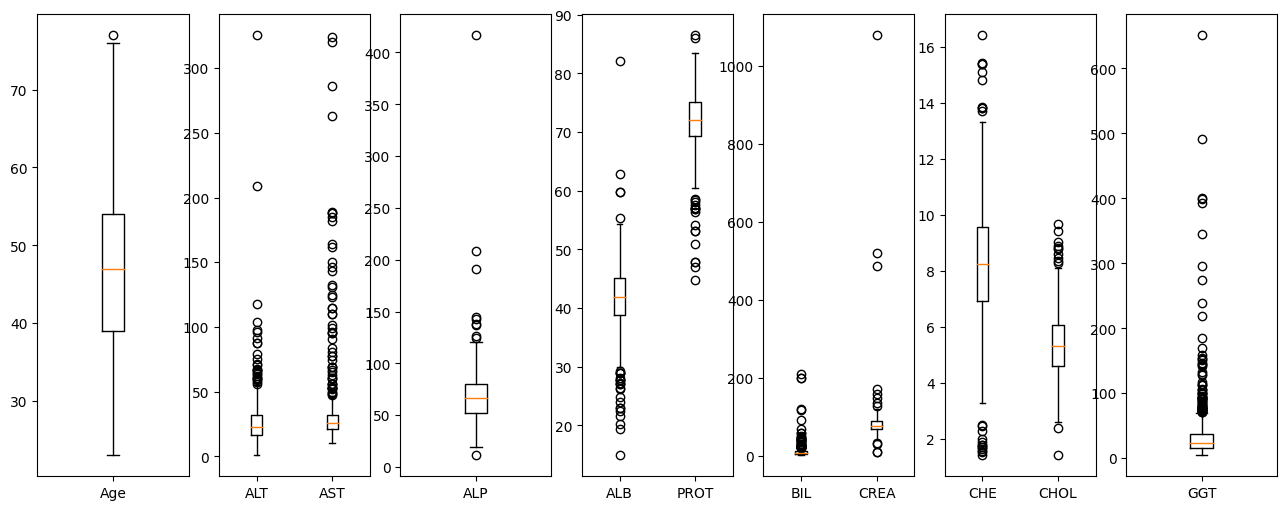

In [ ]:
fig, ax = plt.subplots(1,7,figsize=(16,6))

boxplot_data = [hcv_notna['Age']]
ax[0].boxplot(boxplot_data, labels=['Age']);

boxplot_data = [hcv_notna['ALT'],hcv_notna['AST']]
ax[1].boxplot(boxplot_data, labels = ['ALT', 'AST']);

boxplot_data = [hcv_notna['ALP']]
ax[2].boxplot(boxplot_data, labels=['ALP']);

boxplot_data = [hcv_notna['ALB'],hcv_notna['PROT']]
ax[3].boxplot(boxplot_data, labels = ['ALB', 'PROT']);

boxplot_data = [hcv_notna['BIL'],hcv_notna['CREA']]
ax[4].boxplot(boxplot_data, labels=['BIL','CREA']);

boxplot_data = [hcv_notna['CHE'],hcv_notna['CHOL']]
ax[5].boxplot(boxplot_data, labels=['CHE','CHOL']);

boxplot_data = [hcv_notna['GGT']]
ax[6].boxplot(boxplot_data, labels=['GGT']);

Veamos la correlacion entre nuestras variables:

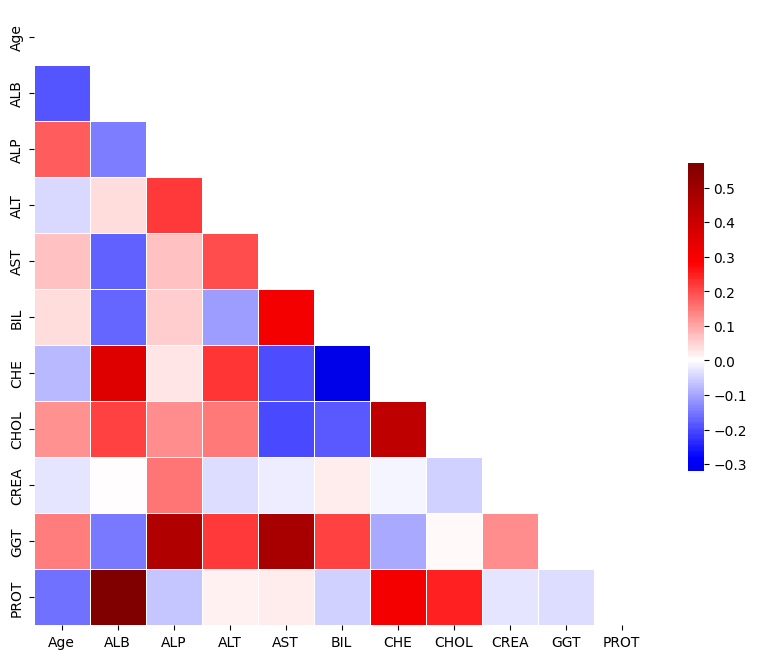

In [ ]:
hepatitis_x = hcv_notna.drop(columns = ['Category', 'Sex', 'Unnamed: 0'])
hepatitis_y = hcv_notna['Category']

hepatitis_frame = pd.DataFrame(hepatitis_x)

corr = hepatitis_frame.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En el heatmap podemos ver correlación directa entre la variable ALB y PROT, AST y GGT, ALP y GGT y por último CHOL y CHE. En cuanto a correlación inversa vemos sobretodo entre BIL y CHE. Cabe indicar que la correlación no es suficientemente grande como para eliminar algunas variables, dado que viendo los rangos de valores a la derecha del heatmap, podemos observar como el valor máximo de correlación directa se sitúa ligeramente por encima de 0.5, y de correlación inversa ligeramente por debajo de -0.3. Por tanto, tomaremos como que todos los atributos son informativos.

Vamos a ver también la relación que hay entre las variables y la variable category utilizando la información mutua.

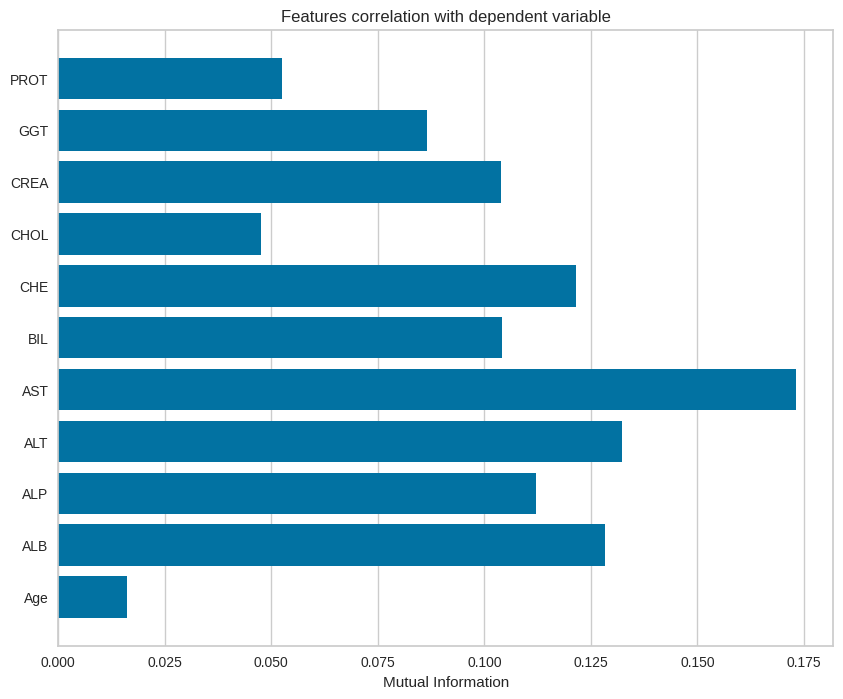

In [ ]:
from yellowbrick.target.feature_correlation import feature_correlation

plt.figure(figsize=(10,8))
visualizer = feature_correlation(hepatitis_frame, hepatitis_y, labels=list(hepatitis_frame.columns), method='mutual_info-classification');

Podemos ver que la variable con más correlación es AST con casi 0.175, seguida de ALT con 0.125 y la que menor correlación tiene es Age que no llega al 0.025.

## Variables categóricas

m    377
f    238
Name: Sex, dtype: int64


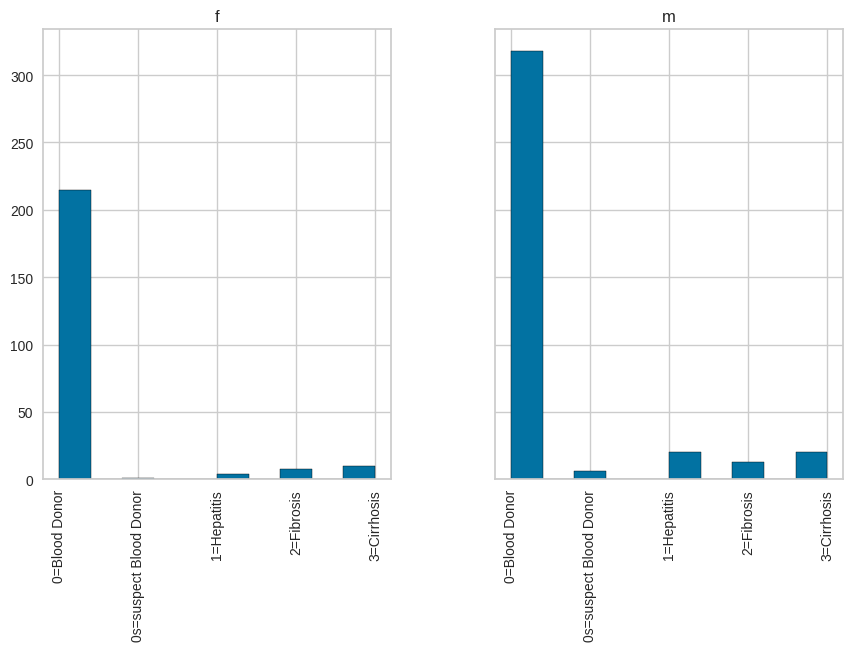

In [ ]:
print(hcv['Sex'].value_counts())
hcv.hist(column='Category',by='Sex',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

Podemos ver que hay 129 hombres más que mujeres en el dataset, esto hace que haya más cantidad de hombres en cada categoría en comparación con las mujeres, en la de blood donor es donde más se puede ver esta diferencia.

## Preprocesado y división de datos

In [ ]:
from sklearn.model_selection import train_test_split

X = hcv.loc[:, hcv.columns != 'Category']
y = hcv['Category']

print(X.shape)
print(y.shape)

(615, 13)
(615,)


Procedemos crear la función de preprocesado, que tiene de entrada el dataset en formato (X,y), preprocesa los datos de la manera que hemos indicado anteriormente, y los separa en train y test, para posteriormente estandarizarlos.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy

def minimum_preprocessing(X_input, y_input):
  X = copy.deepcopy(X_input)
  y = copy.deepcopy(y_input)
  y.replace(['0s=suspect Blood Donor'], ['Blood_donor'], inplace=True)
  y.replace(['0=Blood Donor'], ['Blood_donor'], inplace=True)
  y.replace(['1=Hepatitis'], ['Hepatitis'], inplace=True)
  y.replace(['2=Fibrosis'], ['Fibrosis'], inplace=True)
  y.replace(['3=Cirrhosis'], ['Cirrhosis'], inplace=True)

  print('Tamaño original:{}'.format(X.shape))

  #borramos la columna unnamed, dado que son los indices
  X.drop(columns = ['Unnamed: 0'],inplace = True)

  # remplazar valores faltantes por medias de las columnas que tienen valores perdidos
  for col in columns_to_fill:
    X[col] = X[col].fillna(X[col].mean())

  print('Nuevo tamaño:{}'.format(X.shape))

  #one-hot encoding Sex variable
  sex_dummies = pd.get_dummies(X['Sex'], prefix = 'Sex', drop_first = True)
  X = pd.concat([X,sex_dummies], axis = 1)

  #borrar variable Sex categorica
  X.drop(columns = ['Sex'],inplace = True)

  #comprobar que no faltan números
  X.dropna()
  print('Comprobacion:{}'.format(X.shape))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  scaler = StandardScaler()

  X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
  X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

  return X_train, y_train, X_test, y_test

Aplicamos el preprocesado a nuestros datos, tanto a los de train como a los de test:

In [ ]:
X_train, y_train, X_test, y_test = minimum_preprocessing(X,y)

Tamaño original:(615, 13)
Nuevo tamaño:(615, 12)
Comprobacion:(615, 12)


Es normal que acabemos con una columna menos ya que borramos 2 y una de las que borramos le aplicamos one-hot encoding.

# Apartado B

Aplicad algún método de reducción de dimensionalidad a los datos de entrenamiento y comentad lo que se pueda apreciar en la visualización. Pensad en qué podéis representar sobre la transformación.

En nuestro caso hemos decidio usar el mismo que usamos en el proyecto anterior, que es PCA.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train);

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.2047237  0.15898457 0.12278932 0.09776899 0.08272915 0.07784153
 0.05929695 0.05545815 0.04391625 0.03839364 0.03144626 0.02665149]
[0.2047237  0.36370827 0.48649759 0.58426658 0.66699573 0.74483726
 0.80413421 0.85959236 0.90350861 0.94190225 0.97334851 1.        ]


Mediante la aplicación de la varianza explicada, se observa que al preservar 7 componentes principales, logramos capturar el 80% de la varianza total acumulada, con 8 ya llegamos al 86%. Este umbral del 80% es un criterio comunmente aceptado para determinar el número de componentes a usar. La necesidad de incluir tantas componentes para alcanzar esta cifra indica que nuestro conjunto de datos está caracterizado por una amplia variedad de atributos distintivos, hecho que coincide con lo explicado anteriormente en el análisis de la correlación. Visualicemos la gráfica de la varianza explicada y la varianza explicada por componente.

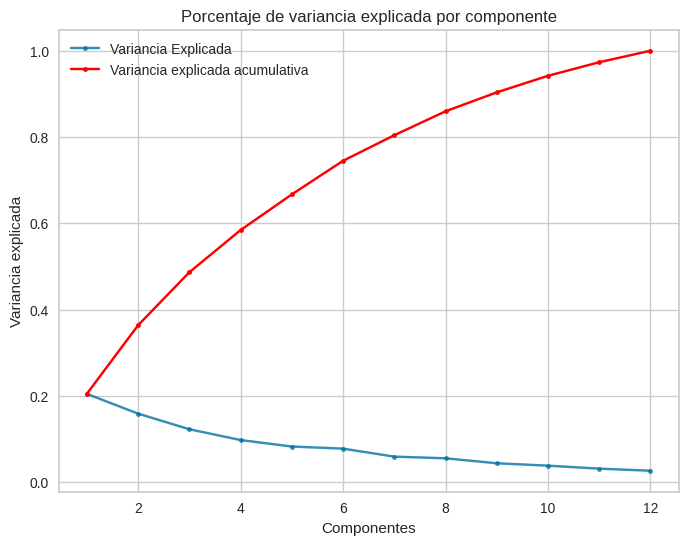

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_ , alpha=0.8, marker='.',
         label="Variancia Explicada");

y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');

plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Variancia explicada acumulativa");

plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Esta seria la varianza entre las variables en función de los componentes utilizados.

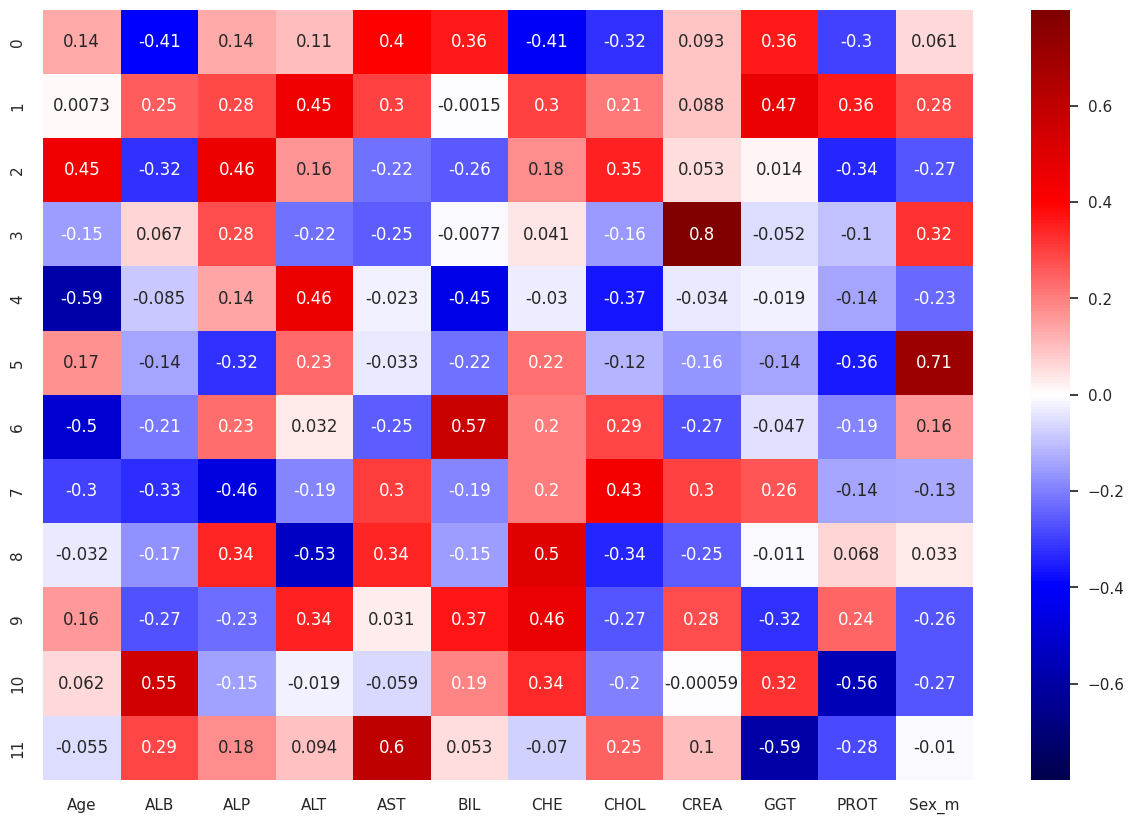

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=X_train.columns,
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

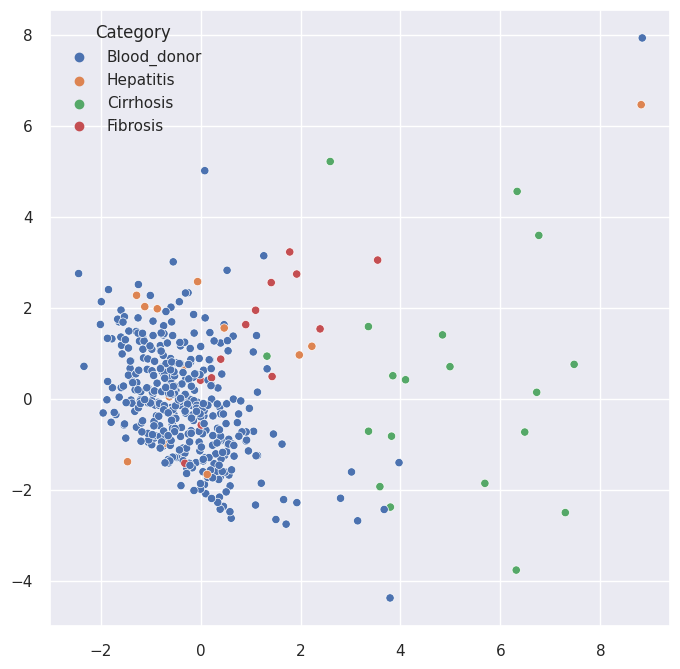

In [ ]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

In [ ]:
print(X_trans.shape)

(430, 12)


Podemos ver que es difícil representar los valores en tan solo 2D, esto es principalmente debido a que necesitamos unos 7 componentes para explicar el modelo completamente. Podemos ver representada la mayor cantidad de la categoría blood_donor respecto a las otras y vemos como cirrhosis parece distribuirse de manera distinta a las demás categorías.

In [ ]:
import plotly.express as px

fig = px.scatter_3d(X_train, x=X_trans[:,0], y=X_trans[:,1], z=X_trans[:,3], color=y_train)
fig.show();

Vemos algo parecido en la representación 3D, ganando un poco de claridad pero no demasiado. Volvemos a ver la gran representación de la categoría blood_donor y como cirrhosis está apartado del resto. Sí que vemos mejor cómo fibrosis se encuentra algo por debajo de blood_donor y no sigue exactamente su misma distribución como parecía en la figura anterior.

Se tendrá en cuenta que a causa del predominio de la clase Blood_donor y la distribución de los puntos, esta clase afectará en los resultados de las predicciones.

## Apartado C

Vamos a usar el modelo de clasificación Naïve Bayes (Gaussiano) para calcular
el acierto de validación cruzada, mirar el informe de clasificación sobre el test y representar su matriz de confusión.

Primero vamos a crear una función donde se guarda los resultados obtenidos de los modelos.

In [ ]:
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')

    return df

results_df = pd.DataFrame()

Hay implementaciones en scikit-learn dependiendo de la distribución de probabilidad que se ajusta a los datos. En este caso los datos son continuos, podemos asumir que se distribuyen según gausianas.

In [ ]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=10)))

0.9186046511627908


Vemos que el valor de validación cruzada es casi del 92% en el set de train, de manera que podemos suponer que es un buen modelo.

In [ ]:
gnb_model = GaussianNB().fit(X_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means = pd.DataFrame(gnb_model.theta_)
means.columns=X_train.columns
means

Priors: [0.89302326 0.04418605 0.03023256 0.03255814]
Means:



,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_m
0,-0.000028,0.070954,0.034797,-0.031843,-0.223494,-0.151026,0.096413,0.090461,-0.067200,-0.154679,-0.019670,-0.029373
1,0.409491,-1.528953,0.660029,-0.310036,2.300111,2.764611,-2.113570,-1.235766,1.598975,1.741182,-0.620831,0.328506
2,0.355994,-0.157455,-0.892801,1.248814,1.611024,0.052393,0.036448,-0.765970,-0.198068,1.019567,0.750587,-0.072724
3,-0.885527,0.275058,-1.021144,0.134555,1.512604,0.341797,0.190102,-0.092854,-0.142915,0.932848,0.685101,0.427351


In [ ]:
print(classification_report(y_test, gnb_model.predict(X_test),target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))


              precision    recall  f1-score   support

 Blood_donor       0.94      0.95      0.95       156
   Hepatitis       0.64      0.64      0.64        11
    Fibrosis       0.33      0.38      0.35         8
   Cirrhosis       0.38      0.30      0.33        10

    accuracy                           0.87       185
   macro avg       0.57      0.57      0.57       185
weighted avg       0.87      0.87      0.87       185



In [ ]:
results_df = save_results(gnb_model, X_test, y_test, 'GNB', results_df)

La precisión media es del 87%, muy parecida a la de la validación cruzada, lo cual es coherente. Podemos ver cómo las precisiones y los valores de *recall* de las variables blood_donor y hepatitis son buenos mientras que los de fibrosis y cirrhosis no lo son, siendo el de cirrhosis el peor con un *recall* de tan solo el 30% y una *precision* del 38%. Podemos suponer que es por el número de ocurrencias de la clase tal y como vemos en la columna de *support*, lo que significa que cualquier clasificación fallida en cualquiera de estas tres clases afecta en gran medida a las métricas.

Vamos a ver en la matriz de confusión que errores se cometen.

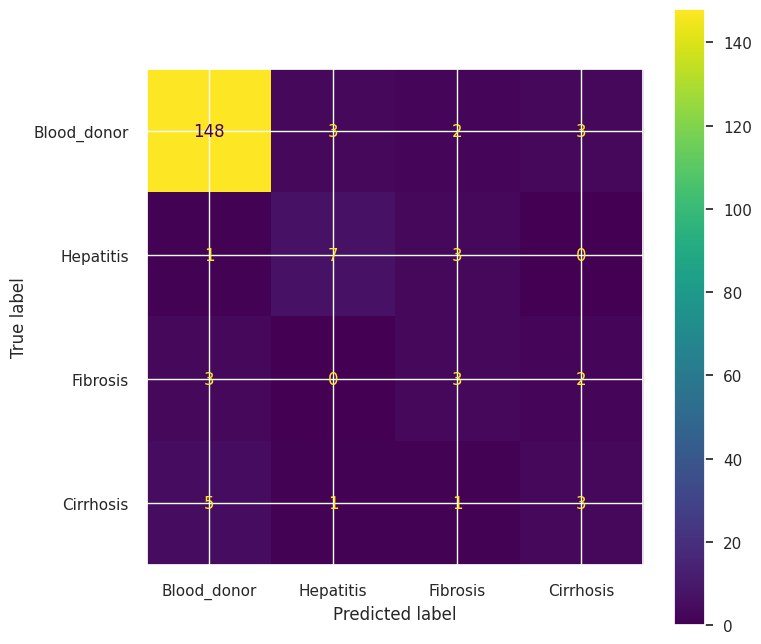

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());


Confirmamos lo visto anteriormente de que fibrosis y cirrhosis son los que peor se clasifican. Nos damos cuenta de que cualquier falso positivo o falso negativo afecta significativamente a la *precision* y al *recall* respectivamente.

Se puede apreciar también que el principal problema con los resultados en las clases de enfermedades puede ser la clase *Blood_donor*. El hecho de que haya tantas ocurrencias de esta clase, comparada con el resto de clases minoritarias, puede hacer que cualquier clasificación fallida afecte en gran medida a las clases minoritarias.

Si nos fijamos en la matriz de confusión, la fila y columna donde hay presentes más clasificaciones fallidas son las de la clase Blood_donor.

Vamos a analizar a continuación las curvas ROC para ver el valor de AUC de cada variable, esta curva representa la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte. El valor **AUC** (area under the curve) será 1 en el caso de un clasificador sin errores, que sería nuestro objetivo.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



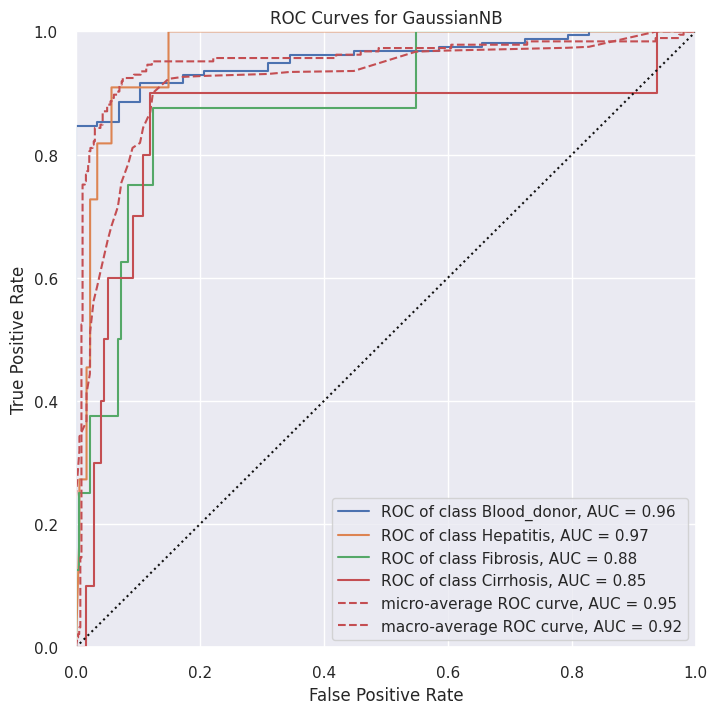

In [ ]:
from yellowbrick.classifier.rocauc import roc_auc

plt.figure(figsize=(8,8));
roc_auc(gnb_model, X_train, y_train, X_test, y_test, classes=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']);

Los resultados de las curvas ROC son buenas, siendo los valores generales del 95% y de todas las clases muy altos, las de blood_donor y hepatitis siendo mejor, tanto en valor como en la inclinación de la recta. Aún así esto nos dice que el modelo funciona ya que todas las variables tiene una probabilidad muy baja de clasificar un elemento negativo aleatorio más alto que un elemento positivo aleatorio.

# Apartado D

Vamos a ajustar un discriminante lineal (LDA) y una regresión logística a los datos, luego exploraremos los hiperparámetros de los modelos que los tengan para discernir si son mejores que Naïve Bayes y si sus resultados en las clases
minoritarias son mejores

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
print(np.mean(cross_val_score(lda,X_train,y_train,cv=10)))

0.9418604651162792


Podemos ver que el acierto es bastante bueno, de un 94%. En este caso no tenemos ningún hiper parámetro que ajustar al ser un *Linear Discriminant Analysis* asi que podemos ajustar el modelo con todos los datos del conjunto de entrenamiento para ver que modelo obtenemos y después podemos comprobar cómo lo hace con el conjunto de test.

Priors: [0.89302326 0.04418605 0.03023256 0.03255814]
Coefs:


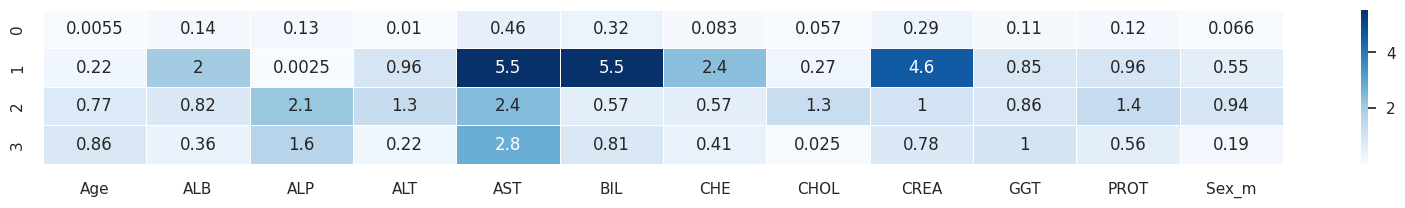

In [ ]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

print('Priors:', lda_model.priors_)

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X_train.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Podemos ver en el modelo cuáles son los atributos más importantes. La tabla de coeficientes nos indica por cada variable y clase, si aumenta en una unidad la clase incrementa su valor por el del coeficiente. Es decir, la magnitud de un coeficiente es indicativo del peso que tendrá esa característica en la clasificación.

En LDA, podemos observar cómo solo da importancia a ciertas características, mientras que en otras asigna coeficientes muy bajos.

Para saber la calidad del modelo podemos aplicarlo a los datos de test. El _classification report_ nos dará todas las medidas que necesitamos para tomar decisiones, aunque no podamos hacer ninguna en este caso.

In [ ]:
print(classification_report(y_test, lda_model.predict(X_test), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
results_df = save_results(lda_model, X_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

 Blood_donor       0.90      0.99      0.94       156
   Hepatitis       1.00      0.27      0.43        11
    Fibrosis       0.33      0.25      0.29         8
   Cirrhosis       0.67      0.20      0.31        10

    accuracy                           0.88       185
   macro avg       0.72      0.43      0.49       185
weighted avg       0.87      0.88      0.85       185



Podemos ver cómo la *precision* y el *recall* de blood_donor es altísima debido a su mayor representación, casi tiene una *recall* perfecta. Por otro lado las demás tienen peores precisiones pero tanto hepatitis como cirrhosis muestran unas precisiones buenas, el primero siendo perfecto y el otro casi al 70%. La *accuracy* general es del 88% pero realmente esto engaña debido a que solo sabemos predecir de manera correcta 1 clase; la *precision* es del 72% si no contamos los pesos debido al mal *recall* de la clase fibrosis.

Vamos a ver también la matriz de confusión para ver que errores se cometen.

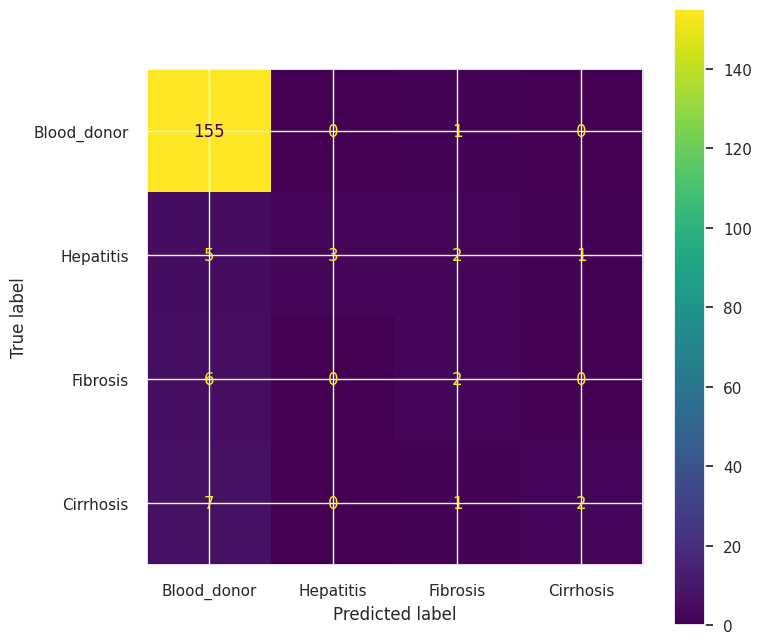

In [ ]:
pplt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test,y_test, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());


Podemos ver de nuevo cómo las clases fibrosis, cirrhosis y hepatitis son las que más se confunden.

Vamos a analizar las curvas ROC.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names



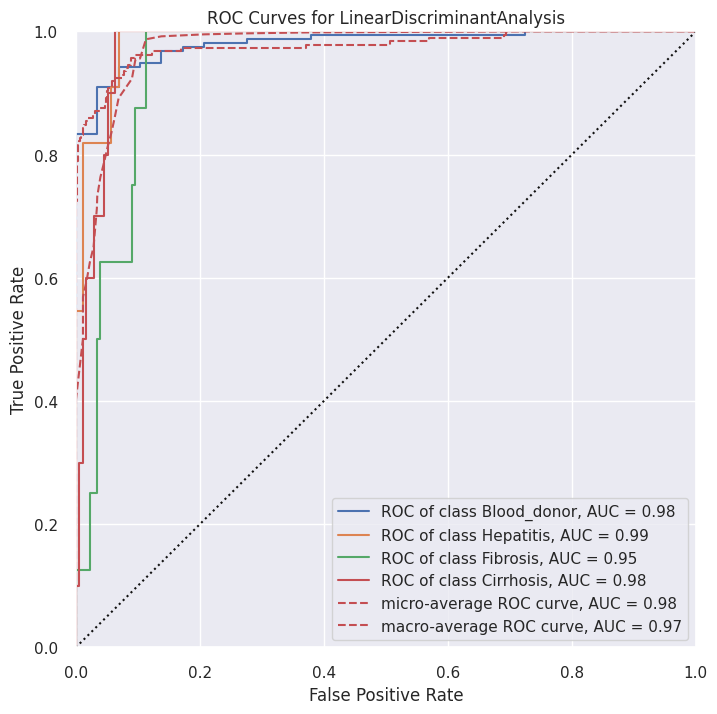

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lda_model, X_train, y_train, X_test, y_test, classes=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']);

Se observa que los valores AUC son muy buenos para todas las clases, la peor es fibrosis con un 94% de AUC de todas maneras. Las inclinaciones son muy buenas a su vez acercándose al modelo ideal. Esto nos indica un clasificador con muy pocos errores.

# Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000, solver = 'liblinear')
print(np.mean(cross_val_score(lr,X_train,y_train,cv=10)))

0.9372093023255814


El acierto obtenido también es muy bueno, del 93.7%, algo peor que con el LDA pero en este modelo si tenemos hiperparámetros que ajustar para mejorar su acierto. Tendremos que aplicar los mejores hiperparámetros y verificar su acierto con ellos.

In [ ]:
from sklearn.model_selection import GridSearchCV

param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.939535,1
41,"{'C': 1000.0, 'penalty': 'l2'}",0.939535,2
24,"{'C': 3.981071705534969, 'penalty': 'l1'}",0.939535,2
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.939535,2
40,"{'C': 1000.0, 'penalty': 'l1'}",0.939535,2


Podemos ver que el mejor resultado es cogiendo como penalty l2 y C = 0.50 pero tenemos varios con la misma score usando otras penalties y valores de C distintos. Hemos obtenido 93.95% de acierto.

Coefs:


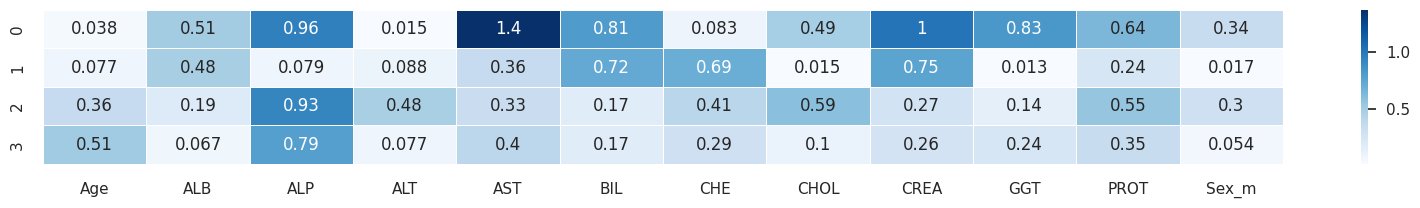

In [ ]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size':12});

Podemos ver unos pesos muy diferentes a aquellos obtenidos con el LDA, aun siendo el ratio de acierto parecido. En este caso, este modelo reparte mucho más los pesos, dando más importancia a todas las características.

In [ ]:
print(classification_report(y_test, lr_gs.predict(X_test),target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))

results_df = save_results(lr_gs, X_test, y_test, 'Logistic', results_df)

              precision    recall  f1-score   support

 Blood_donor       0.89      0.99      0.94       156
   Hepatitis       0.67      0.36      0.47        11
    Fibrosis       0.25      0.12      0.17         8
   Cirrhosis       1.00      0.10      0.18        10

    accuracy                           0.87       185
   macro avg       0.70      0.40      0.44       185
weighted avg       0.86      0.87      0.84       185



Podemos ver la misma tendencia a la que teníamos con el LDA, donde blood_Donor realiza una predicción muy buena, casi idéntica a la anterior, pero las demás son muy malas. Hemos mejorado la precisión de hepatitis un 10% a costa de reducir por otro 10% la de fibrosis y cirrhosis. En cuanto al *recall* hemos cambiado los valores de hepatitis y cirrhosis que teníamos antes y hemos empeorado ligeramente el de fibrosis. Tenemos una precisión media igual debido a que la mayor importancia está en blood_donor y el *recall* general ha quedado muy parecido.

Vamos a analizar la matriz de confusión para confirmar nuestras sospechas.

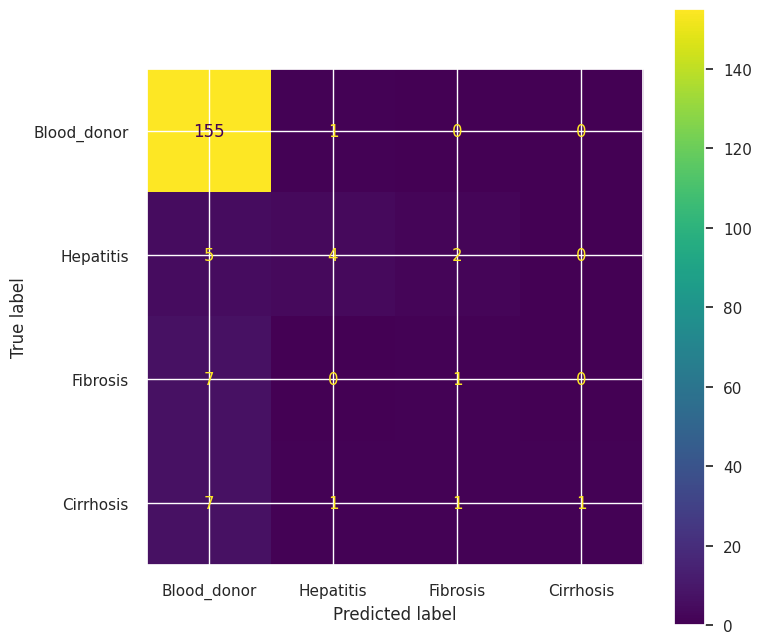

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

Podemos ver que es la misma matriz de confusión que teníamos con el LDA con ligeros cambios en los valores. Podemos ver una ligera mejora en fibrosis y cirrhosis en la primera columna.

Vamos a analizar las curvas ROC.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



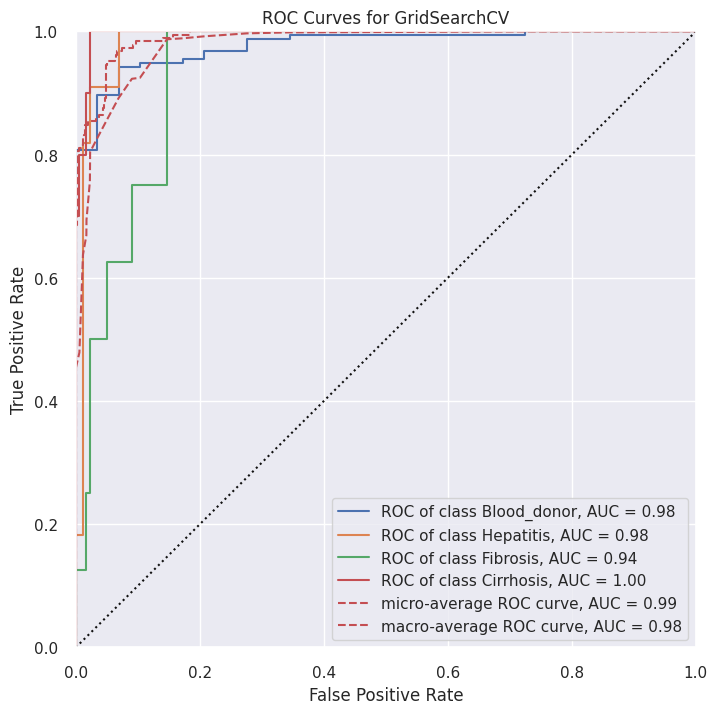

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train, y_train, X_test, y_test, classes=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']);

Podemos ver que el valor de AUC general y por categorias se ha quedado igual, en cuanto a las curvas la de blood_donor podríamos decir que ha empeorado de manera muy ligera aun siendo muy cercana al ideal,  la de fibrosis también parece ligeramente peor mientras que las otras dos han mejorado ligeramente.

# Conclusión de los tres modelos

Vamos a comparar los resultados

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
LDA,0.875676,0.865417,0.875676,0.849015
GNB,0.870270,0.867427,0.870270,0.868562
Logistic,0.870270,0.855669,0.870270,0.837154


Podemos ver que los aciertos son muy parecidos, siendo la de LDA el mejor seguida de GNB y logistic que tienen el mismo acierto. En cuanto a la precisión el de GNB tiene algo más que los demás y de *recall* tiene LDA algo mas que el resto.

Si nos guiáramos puramente por la *accuracy*, elegirámos LDA.

Si nos guiáramos por los dos siguientes contextos:

- En el caso de que queramos buscar donantes de sangre se buscará una mayor precisión. Preferiremos evitar que una persona que tiene enfermedades done sangre (reducir falsos positivos)

- En el caso de prevenir enfermedades se buscará un mayor recall, de manera que se preferirá indicar a la persona que tiene la enfermedad cuando en realidad no la tiene (reducir falsos negativos)

Siguiendo este último criterio, la elección seria de Naïve Bayes, dado que tiene una mayor precisión para la clase *Blood_donor*, con una *precision* de 0.94, y una mayor media de *recall* entre las 3 clases minoritarias, con un *recall* de 0.44.

# Apartado E

Ahora vamos a intentar mejorar los resultados utilizando minimización de riesgos vecinales. Este método establece que podemos abordar el aprendizaje utilizando una estimación de la densidad alrededor de los ejemplos. Por tanto, procederemos a realizar un aumento de los datos de las tres clases minoritarias, suponiendo que la densidad alrededor de un ejemplo es gaussiana y aplicando ruido gaussiano a los ejemplos creados.

Primero repetiremos el preprocesado minimo y juntaremos de nuevo X_train y X_test con y_train y y_test respectivamente.

De esta manera, conseguimos las tablas enteras preprocesadas, pero separadas en train y test.

In [ ]:
X_train_copy, y_train_copy, X_test_copy, y_test_copy = minimum_preprocessing(X, y)

data_preprocessed = X_train_copy.merge(y_train_copy,left_index=True, right_index=True)

Tamaño original:(615, 13)
Nuevo tamaño:(615, 12)
Comprobacion:(615, 12)


A continuación, procedemos a definir las funciones para el aumento de los datos:

In [ ]:
from jax import random

def resample_with_gaussian_noise(df, target_size, variance, key):
  for cat in ["Hepatitis", "Fibrosis", "Cirrhosis"]:
    df_cat = df[df['Category'] == cat]
    df_cat = add_rows(df_cat, target_size, variance, key)
    df = pd.concat([df, df_cat], ignore_index=True)
  df.drop_duplicates(inplace=True)
  return df

def add_rows(df_cat, target_size, variance, key):
  number_of_new_rows = target_size - df_cat.shape[0]
  zeros = np.zeros((df_cat.shape[0], 10))
  noises_array = np.asarray((random.normal(key, (number_of_new_rows, 10)) * variance))
  noises_array = np.concatenate((zeros, noises_array), axis=0)
  noises = pd.DataFrame(noises_array, columns=df_cat.columns[1:-2])
  df_cat = pd.concat([df_cat]*int(1 + target_size/df_cat.shape[0]))
  df_cat.reset_index(drop=True, inplace=True)
  df_cat = df_cat.iloc[:target_size,:]
  df_cat.iloc[:,1:-2] += noises
  df_cat.drop_duplicates(inplace=True)
  return df_cat

Aplicamos el data augmentation a las 4 combinaciones de (número de ejemplos, varianza del ruido gaussiano), y posteriormente ajustamos un discriminante lineal y una regresión logística para evaluar los resultados.

In [ ]:
key1, key2, key3, key4 = random.split(random.PRNGKey(0),4)
set_A = resample_with_gaussian_noise(data_preprocessed, 500, 0.1, key1)
X_set_A = set_A[set_A.columns[0:-1]]
y_set_A = set_A['Category']

set_B = resample_with_gaussian_noise(data_preprocessed, 500, 0.01, key2)
X_set_B = set_B[set_A.columns[0:-1]]
y_set_B = set_B['Category']

set_C = resample_with_gaussian_noise(data_preprocessed, 1000, 0.1, key3)
X_set_C = set_C[set_A.columns[0:-1]]
y_set_C = set_C['Category']

set_D = resample_with_gaussian_noise(data_preprocessed, 1000, 0.01, key4)
X_set_D = set_D[set_A.columns[0:-1]]
y_set_D = set_D['Category']

### LDA

In [ ]:
lda_model_A = LinearDiscriminantAnalysis().fit(X_set_A, y_set_A)
lda_model_B = LinearDiscriminantAnalysis().fit(X_set_B, y_set_B)
lda_model_C = LinearDiscriminantAnalysis().fit(X_set_C, y_set_C)
lda_model_D = LinearDiscriminantAnalysis().fit(X_set_D, y_set_D)

In [ ]:
print("Con el modelo LDA se obtienen los siguientes resultados\n\n")
print("Conjunto 500 - 0.1\n--------------------\n" , classification_report(y_test_copy, lda_model_A.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 500 - 0.01\n--------------------\n" , classification_report(y_test_copy, lda_model_B.predict(X_test_copy),target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 1000 - 0.1\n--------------------\n" , classification_report(y_test_copy, lda_model_C.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 1000 - 0.01\n--------------------\n" , classification_report(y_test_copy, lda_model_D.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))

Con el modelo LDA se obtienen los siguientes resultados


Conjunto 500 - 0.1
--------------------
               precision    recall  f1-score   support

 Blood_donor       0.96      0.76      0.85       156
   Hepatitis       0.50      0.45      0.48        11
    Fibrosis       0.30      0.75      0.43         8
   Cirrhosis       0.22      0.70      0.33        10

    accuracy                           0.74       185
   macro avg       0.49      0.67      0.52       185
weighted avg       0.86      0.74      0.78       185

Conjunto 500 - 0.01
--------------------
               precision    recall  f1-score   support

 Blood_donor       0.96      0.76      0.85       156
   Hepatitis       0.50      0.45      0.48        11
    Fibrosis       0.30      0.75      0.43         8
   Cirrhosis       0.22      0.70      0.33        10

    accuracy                           0.74       185
   macro avg       0.49      0.67      0.52       185
weighted avg       0.86      0.74      0.78 

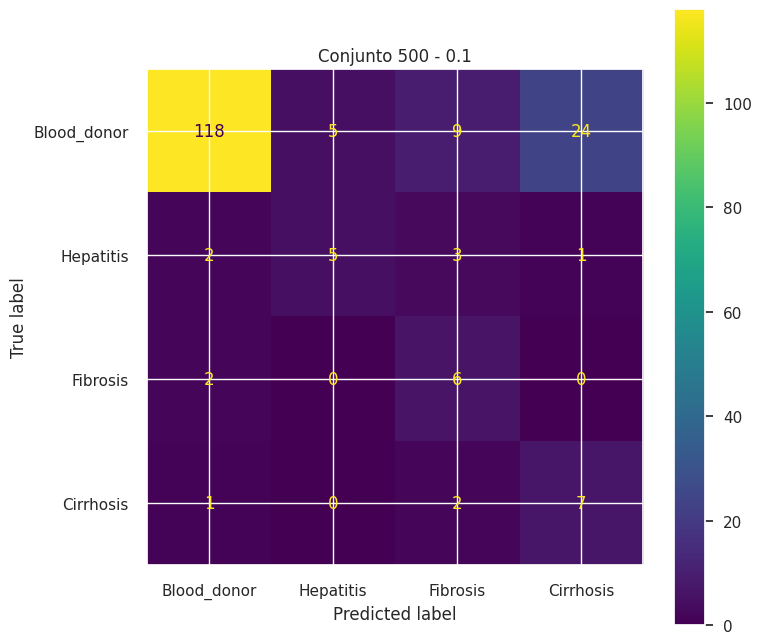

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 500 - 0.1")
ConfusionMatrixDisplay.from_estimator(lda_model_A, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

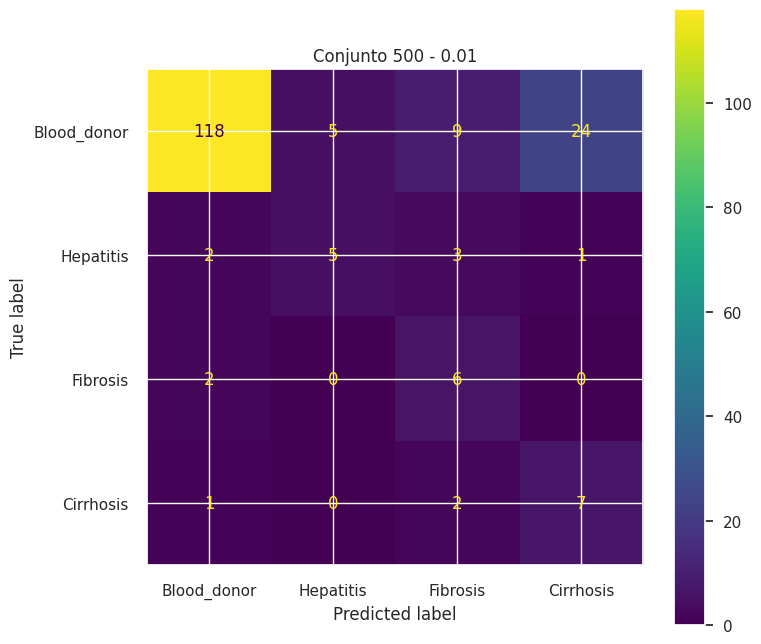

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 500 - 0.01")
ConfusionMatrixDisplay.from_estimator(lda_model_B, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

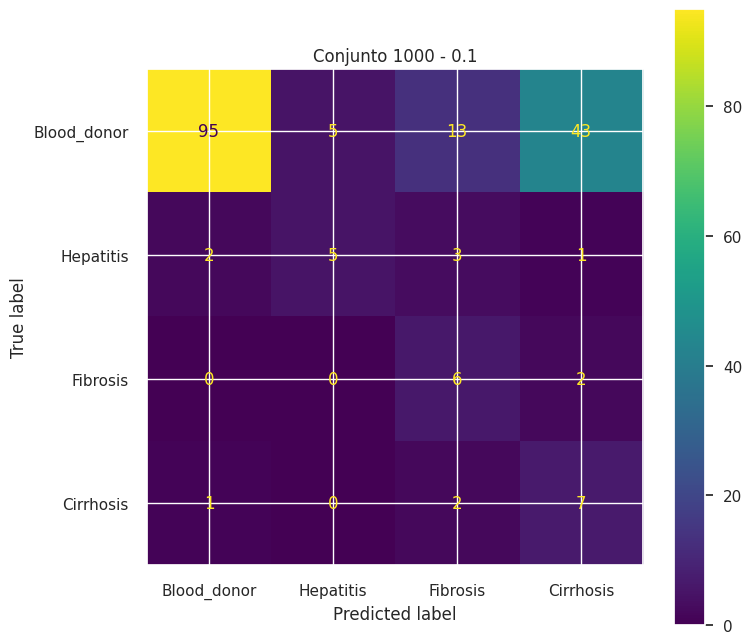

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 1000 - 0.1")
ConfusionMatrixDisplay.from_estimator(lda_model_C, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

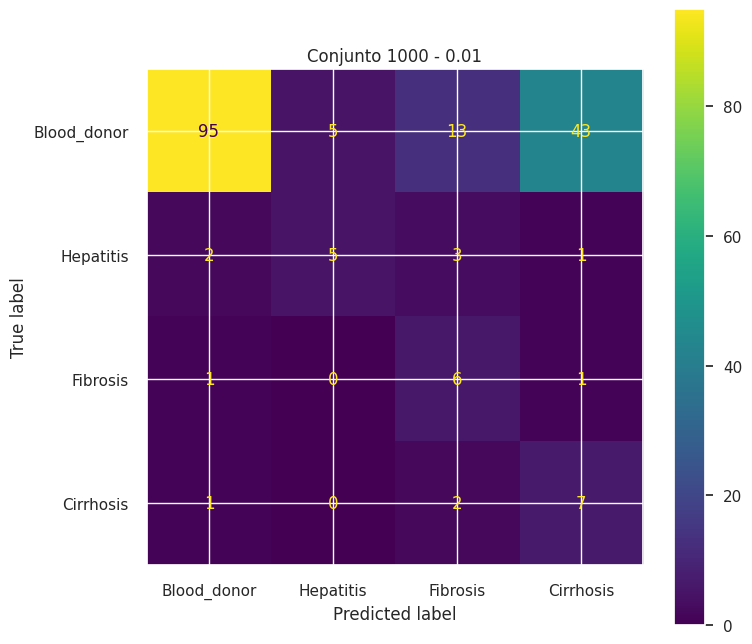

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 1000 - 0.01")
ConfusionMatrixDisplay.from_estimator(lda_model_D, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

### Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000, solver='liblinear')
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,25, endpoint=True)}

lr_gs_A =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_A.fit(X_set_A, y_set_A);

lr_gs_B =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_B.fit(X_set_B, y_set_B);

lr_gs_C =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_C.fit(X_set_C, y_set_C);

lr_gs_D =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_D.fit(X_set_D, y_set_D);

In [ ]:
print("Con el modelo de regresión lineal se obtienen los siguientes resultados\n\n")
print("Conjunto 500 - 0.1\n--------------------\n" , classification_report(y_test_copy, lr_gs_A.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 500 - 0.01\n--------------------\n" , classification_report(y_test_copy, lr_gs_B.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 1000 - 0.1\n--------------------\n" , classification_report(y_test_copy, lr_gs_C.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))
print("Conjunto 1000 - 0.01\n--------------------\n" , classification_report(y_test_copy, lr_gs_D.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))

Con el modelo de regresión lineal se obtienen los siguientes resultados


Conjunto 500 - 0.1
--------------------
               precision    recall  f1-score   support

 Blood_donor       0.98      0.85      0.91       156
   Hepatitis       0.67      0.55      0.60        11
    Fibrosis       0.33      0.62      0.43         8
   Cirrhosis       0.27      0.70      0.39        10

    accuracy                           0.81       185
   macro avg       0.56      0.68      0.58       185
weighted avg       0.89      0.81      0.84       185

Conjunto 500 - 0.01
--------------------
               precision    recall  f1-score   support

 Blood_donor       0.98      0.86      0.91       156
   Hepatitis       0.70      0.64      0.67        11
    Fibrosis       0.38      0.62      0.48         8
   Cirrhosis       0.28      0.70      0.40        10

    accuracy                           0.83       185
   macro avg       0.59      0.71      0.61       185
weighted avg       0.90     

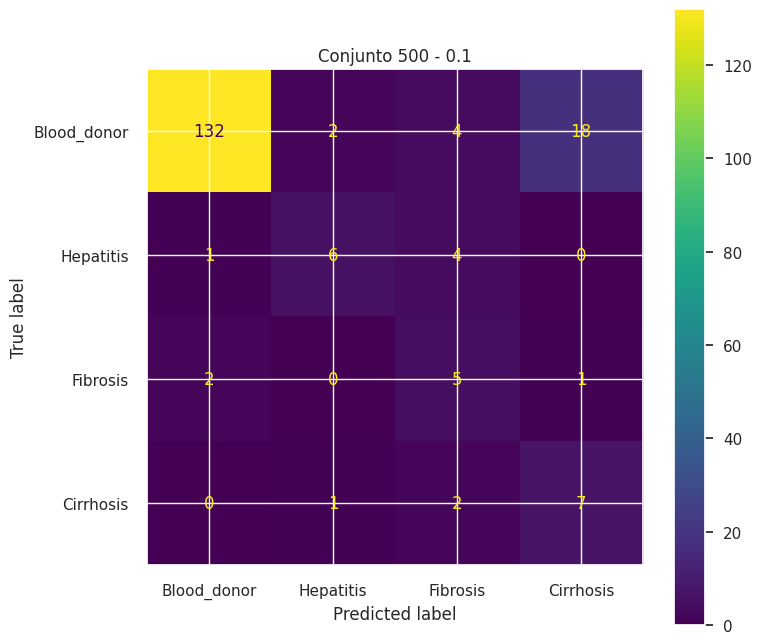

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 500 - 0.1")
ConfusionMatrixDisplay.from_estimator(lr_gs_A, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

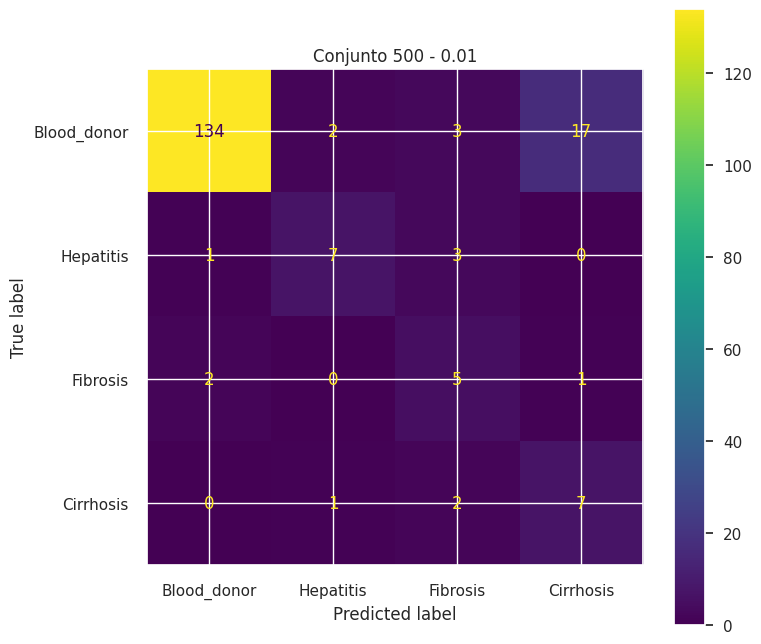

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 500 - 0.01")
ConfusionMatrixDisplay.from_estimator(lr_gs_B, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

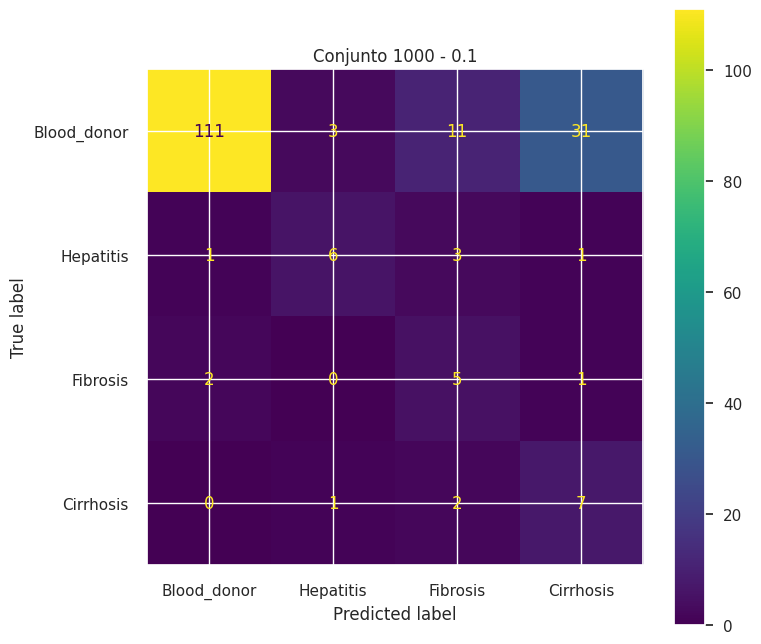

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 1000 - 0.1")
ConfusionMatrixDisplay.from_estimator(lr_gs_C, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

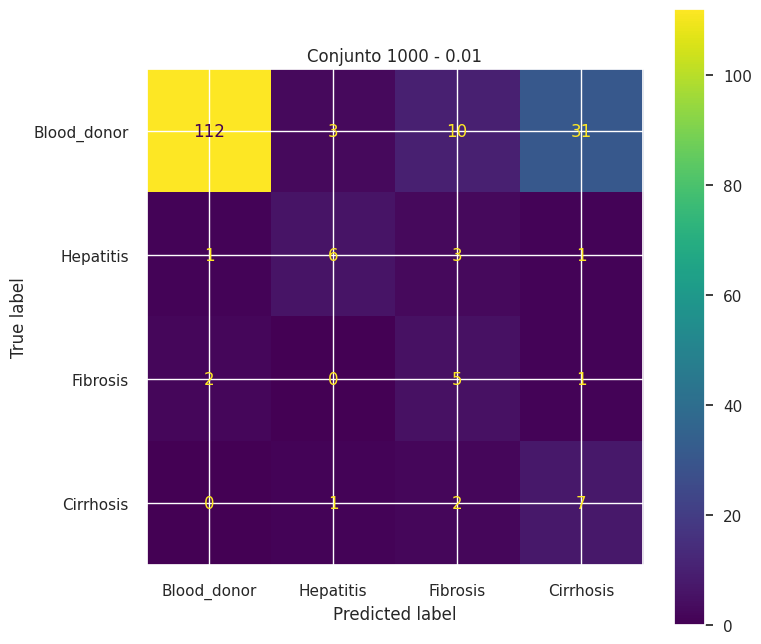

In [ ]:
plt.figure(figsize=(8,8));
plt.title("Conjunto 1000 - 0.01")
ConfusionMatrixDisplay.from_estimator(lr_gs_D, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

Siguiendo el mismo criterio de los dos contextos mencionado en el apartado D, después de analizar los datos de todos los modelos, hemos llegado a la conclusión de que el mejor modelo es *Logistic Regression* con parámetros conjunto 500 y 0.01 de varianza.

El motivo es que para el caso de donante de sangre es el que mejor *precision* tiene con un 0.98, equivalente al del mismo modelo pero con 0.1 de varianza, pero por lo que respecta al *recall*, es el que más media tiene en cuanto a las enfermedades con una media de 0.65.

Ha habido mejora en los resultados respecto el apartado anterior, dado que hemos pasado de una *precision* de 0.94 a 0.98, y de un *recall* medio de las clases minoritarias de 0.44 a 0.65.

El efecto de los datos adicionales ha sido que ha estabilizado más los resultados de las clases minoritarias, causados por el desbalance de muestras entre estas y la clase *Blood_donor*, dando paso a un aumento de la *precision* y el *recall* más representativos.

# Apartado F

Ahora procederemos a ver los resultados ajustando el modelo de regresión logística con el parámetro *class_weight* en la opción *balanced*, de manera que pondere las clases según sus frecuencias.

In [ ]:
lr = LogisticRegression(max_iter=10000, solver='liblinear')

param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,25, endpoint=True), 'class_weight':['balanced']}
lr_weighted =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_weighted.fit(X_train_copy, y_train_copy);

In [ ]:
show_html(pd.DataFrame(lr_weighted.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 0.03162277660168379, 'class_weight': 'balanced', 'penalty': 'l2'}",0.939535,1
16,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}",0.937209,2
15,"{'C': 0.05623413251903491, 'class_weight': 'balanced', 'penalty': 'l2'}",0.937209,2
11,"{'C': 0.01778279410038923, 'class_weight': 'balanced', 'penalty': 'l2'}",0.937209,2
23,"{'C': 0.5623413251903491, 'class_weight': 'balanced', 'penalty': 'l2'}",0.934884,5


Coefs:


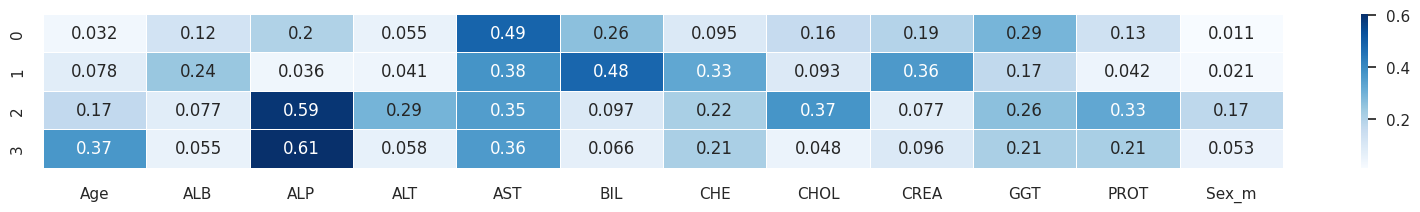

In [ ]:
print('Coefs:')
coefs = pd.DataFrame(lr_weighted.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size':12});

Este modelo reparte los pesos de los coeficientes aún más que los modelos anteriores, lo que puede indicar que cuanto más se repartan los pesos, mejores resultados se obtienen. Esto puede venir también de la poca correlación entre características, por tanto cuanta más información aporten todas las características en general, mejores predicciones realizaremos.

In [ ]:
print(classification_report(y_test_copy, lr_weighted.predict(X_test_copy), target_names=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']))

              precision    recall  f1-score   support

 Blood_donor       0.96      0.97      0.96       156
   Hepatitis       0.70      0.64      0.67        11
    Fibrosis       0.33      0.50      0.40         8
   Cirrhosis       1.00      0.60      0.75        10

    accuracy                           0.91       185
   macro avg       0.75      0.68      0.70       185
weighted avg       0.92      0.91      0.91       185



In [ ]:
results_df = save_results(lr_weighted, X_test_copy, y_test_copy, 'Logistic with weights', results_df)

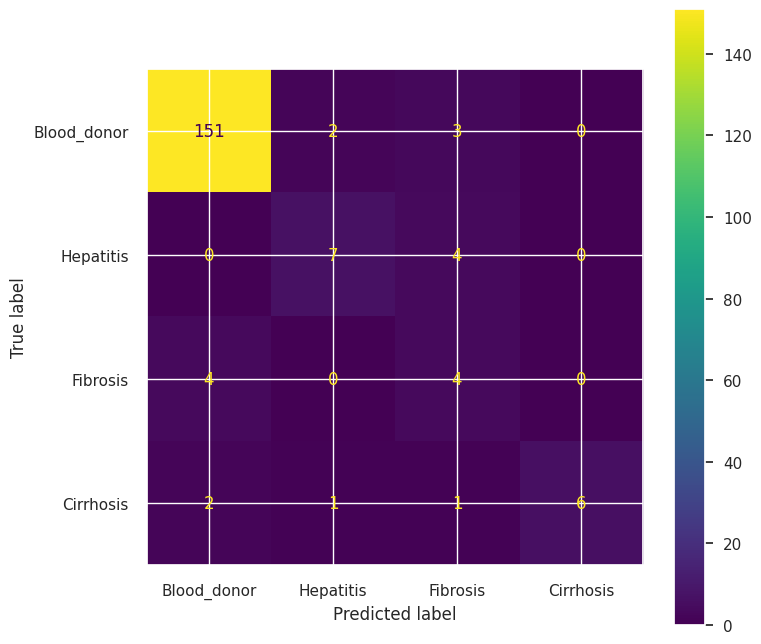

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_weighted, X_test_copy,y_test_copy, display_labels=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis'], ax=plt.subplot());

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



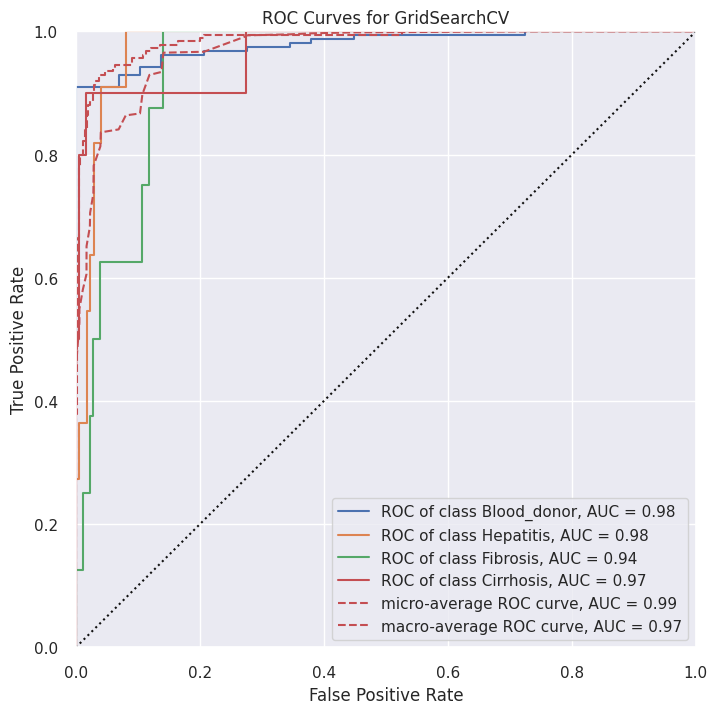

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lr_weighted, X_train_copy, y_train_copy, X_test_copy, y_test_copy, classes=['Blood_donor','Hepatitis','Fibrosis','Cirrhosis']);

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic with weights,0.908108,0.921107,0.908108,0.911086
LDA,0.875676,0.865417,0.875676,0.849015
GNB,0.870270,0.867427,0.870270,0.868562
Logistic,0.870270,0.855669,0.870270,0.837154


Viendo los datos de este último modelo, vemos el buen resultado que ha obtenido sin necesitar de *data augmentation*. Ha conseguido la mejor *accuracy* con un 0.91, ha mantenido una buena *precision* tanto únicamente para la clase *Blood_donor* como en general, y una buena *recall* también tanto para las 3 clases minoritarias como en general.